---
title: |
    Supplementary Material
subtitle: |
    Enabling empirical SPI target derivation using *a priori* soundscape rankings and multi-objective optimisation
abstract: |
  This document provides detailed technical information supporting the multi-objective optimization method presented in Section IV.B.1 of *Soundscape Perception Indices (SPI): Developing context-dependent single value scores of multidimensional soundscape perceptual quality.* The optimization method enables systematic derivation of SPI target distributions from empirical soundscape quality rankings. The method is based on the optimization of a set of objective functions that are designed to capture the most important aspects of soundscape perception. The optimization is performed using a genetic algorithm, which is a stochastic optimization method that is well-suited to the multi-objective optimization problem of deriving SPI targets.
description: |
  Code accompanying the paper: "Soundscape Perception Indices: "
author:
  - name: Andrew Mitchell
    email: a.j.mitchell@ucl.ac.uk
    affiliations: 
        - id: ucl-iede
          name: University College London
          department: Bartlett School of Sustainable Construction
          city: London
          state: UK
    attributes:
        corresponding: true
    orcid: 0000-0003-0978-5046
# format:
#   elsevier-pdf:
#     echo: true
#     keep-tex: true
#     keep-ipynb: true
#     journal:
#       name: Journal of the Acoustical Society of America
#       formatting: preprint
#       model: 3p
#       cite-style: authoryear

date: last-modified
---

# Code setup

This analysis uses the following Python (v3.11.8) packages:

* `pymoo` v0.6.1.3 [@pymoo]
* `soundscapy` v0.7.4 [@Mitchell2024Soundscapy; @Mitchell2023How]
* `KS2D` [@Taillon20182DKS]
* `rpy2` v3.5.12 [https://rpy2.github.io](https://rpy2.github.io)

And the following R (v4.4.1) package for MSN fitting and sampling:

* `sn` v2.1.1 [@Azzalini2023R]

In [1]:
#| warning: false

# Import libraries

import warnings

import numpy as np
import pandas as pd
import soundscapy as sspy
from soundscapy.surveys.survey_utils import LANGUAGE_ANGLES, PAQ_IDS

import scripts.optimize_target as ot # import scripts
from scripts.MultiSkewNorm import MultiSkewNorm

warnings.filterwarnings("ignore")

/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


# Role of *a priori* rankings in target definition

The core challenge in developing a reference SPI target is determining what constitutes an "ideal" soundscape perception distribution for a given context. While we can directly specify MSN parameters to create bespoke targets based on theoretical expectations or design goals, developing empirically-grounded reference targets requires a more systematic approach.

The *a priori* ranking serves as a bridge between existing knowledge about soundscape quality and the mathematical framework of the SPI. By starting with a ranking of soundscapes whose relative quality has been assessed through some external measure (in this demonstration, mean SSS01 scores, though other metrics could be used), we can use optimization techniques to derive MSN parameters that:

1. When used as an SPI target, produce scores that result in the same ranking order
2. Generate high SPI scores for the highly-ranked soundscapes
3. Define a distribution in the circumplex space that captures the perceptual characteristics common to high-quality soundscapes in this context

This approach allows us to work backwards from known good (and poor) examples to define what the target distribution should look like. For instance, if we know that location A has a better soundscape than location B for our purposes, the optimal target distribution should result in location A receiving a higher SPI score than location B.

## Example using park soundscapes from the ISD

To demonstrate the method of deriving an SPI target from empirical data, we used a subset of locations from the International Soundscape Database (ISD) [@Mitchell2021International] that were classified as parks or park-like spaces.

In [2]:
# Load latest ISD dataset

data = sspy.isd.load()
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers (the below code resulted in the `excl_id` list)
# excl_id = list(data.query(
    # "LocationID == 'RegentsParkJapan'"
    # ).query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query(
    # "LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)

# Calculate ISOPleasant and ISOEventful
# Here we use the adjusted angles from Aletta et al. (2024) for each language included.
for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.processing._adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.processing._adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

The following locations were identified as parks and included:

In [3]:
# Separate out parks

parks = [
    "RegentsParkFields",
    "RegentsParkJapan",
    "Noorderplantsoen",
    "StPaulsCross",
    "MiradorSanNicolas",
    "RussellSq",
    "Noorderplantsoen",
    "MonumentoGaribaldi",
    "CampoPrincipe",
]

park_data = data.query("LocationID in @parks")

An initial ranking of these locations was created based on their mean SSS01 scores (overall soundscape quality rating) from the survey responses in the ISD:

In [4]:
# Creating a somewhat arbitrary ranking of parks
rank_on = "sss01"
park_quality = pd.DataFrame(
    park_data.groupby("LocationID")[rank_on].mean().sort_values(ascending=False)
)
park_quality["Rank"] = range(1, len(park_quality) + 1)
park_quality.head(10)

,sss01,Rank
LocationID,,
RegentsParkJapan,4.617978,1
RegentsParkFields,4.467290,2
CampoPrincipe,4.345455,3
MonumentoGaribaldi,4.156250,4
RussellSq,4.020548,5
MiradorSanNicolas,3.964286,6
StPaulsCross,3.803030,7
Noorderplantsoen,2.412371,8


It's important to note that, as stated in the main paper, this ranking is used primarily to demonstrate the methodology of deriving a target from a pre-existing ranking. While based on real survey data, this particular ranking should not be considered a definitive assessment of these spaces' soundscape quality, due to the mono-dimensional nature of the SSS01 question. To develop a true reference target, the ranking would need to be arrived at through more rigorous empirical methods such as paired-choice comparisons or other experimental protocols.
The purpose of using this ranking is twofold:

1. To demonstrate that the SPI framework can incorporate existing knowledge or preferences about soundscape quality into the target definition process
2. To show how multi-objective optimization can be used to derive MSN parameters that produce an SPI scoring system aligned with predetermined quality assessments

# Optimisation Task Formulation

## SPI Targets {#sec-targets}

To set up the optimisation task, we first need to express the parameter space and any constraints. The SPI target is a set of parameters that define the distribution of soundscape perception in a given soundscape. The target is defined as a multivariate skew-normal (MSN) distribution with the following parameters:

$$
Y \sim MSN(\xi, \Omega, \alpha)
$$ {#eq-target}

where:

$$
\xi = (\xi_x, \xi_y), -1 \leq \xi \leq 1
$$ {#eq-target-xi}

is the location parameter, which defines the mean of the distribution in the x and y dimensions. The location parameter is constrained to lie within the range $-1 \leq \xi \leq 1$ to ensure that the target distribution is within the range of possible soundscape perceptions (i.e. within the circumplex).

$$
\Omega = \begin{pmatrix} var(x) & cov(x, y) \\ cov(y, x) & var(y) \end{pmatrix}
$$ {#eq-target-omega}

and

$$
0 \leq var() \leq 1; -1 \leq cov() \leq 1
$$ {#eq-target-omega-constraints}

is the covariance matrix, which defines the shape of the distribution. The covariance matrix must be symmetric $(cov(x,y) = cov(y,x))$ and positive definite to ensure that the distribution is well-defined. These requirements arise from the mathematical properties needed for a valid probability distribution. The variance and covariance parameters are constrained within realistic ranges based on observed soundscape distributions in the ISD.

$$
\alpha = (\alpha_x, \alpha_y), -50 \leq \alpha \leq 50
$$ {#eq-target-alpha}

is the skewness parameter, which defines the skewness of the distribution in the x and y dimensions.

## Objective Functions

Our optimization problem requires carefully chosen objective functions that can effectively translate an ordinal ranking of soundscape quality into meaningful MSN parameters. Two competing objectives are defined to ensure the resulting target distribution is both valid and useful:


1. Rank Correlation Objective:

    $$
    f_1 = r(ranks_{quality}, ranks_{target})
    $$ {#eq-rank-obj}

    where $r$ is the Spearman rank correlation coefficient. This objective ensures the derived target preserves the original quality ordering of the soundscapes. A high rank correlation indicates that when the target is used to calculate SPI scores for each location, those scores produce a similar ranking to our *a priori* assessment.

2. Weighted SPI Objective:

    $$
    f_2 = \sum_{i=1}^{m} \frac{1}{rank_i} \cdot SPI_i
    $$ {#eq-spi-obj}

    where $m$ is the number of locations and $rank_i$ is the *a priori* rank of location $i$. This objective addresses several important aspects:

    * It ensures the target produces meaningfully scaled scores, not just correct rankings
    * The weighting ($\frac{1}{rank_i}$) prioritizes high SPI scores for locations ranked as high quality
    * It prevents solutions that achieve the correct ranking but with compressed or arbitrary score ranges
    * It helps anchor the target distribution in regions of the circumplex space associated with positive soundscape experiences for this context.

The two objectives work together to resolve key challenges in target derivation:

* Rank correlation alone could produce valid but impractical targets (e.g., targets that correctly rank soundscapes but give very low scores to all locations)
* Weighted scores alone might maximize scores without preserving the relative quality relationships
* Together, they ensure the target both discriminates between soundscape quality levels and produces scores that reflect absolute quality judgments

In `pymoo`, each objective function is supposed to be minimized. Therefore, in the code implementation these objectives are negated to convert them into minimization problems. For each step in the algorithm with a given trial set of parameters, a target distribution will be produced, the SPI for each test location assessed according to the protocol described in the full paper, and the resulting set of SPI scores and ranking will be scored using the objective functions.

## NSGA-II Problem Definition in `pymoo`

In [5]:
import pathos
from pymoo.core.callback import Callback
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from pymoo.visualization.scatter import Scatter
from pyrecorder.recorder import Recorder
from pyrecorder.writers.streamer import Streamer
from pyrecorder.writers.video import Video
from pymoo.decomposition.asf import ASF


class MyProblem(ElementwiseProblem):
    def __init__(self, data, ranking, **kwargs):
        super().__init__(
            n_var=7,
            n_obj=2,
            n_constr=0,
            xl=np.array([-1, -1, 0, 0, -1, -50, -50]),
            xu=np.array([1, 1, 0.5, 0.5, 1, 50, 50]),
            n_eq_constr=1,
            elementwise_evaluation=True,
            **kwargs,
        )

        self.data = data
        self.ranking = ranking

    def _evaluate(self, X, out, *args, **kwargs):
        # Check if the matrix is positive definite
        h = 1 - int(
            np.all(np.linalg.eigvals(np.array([[X[2], X[4]], [X[4], X[3]]])) > 0)
        )
        out["H"] = h
        if h != 0:
            out["F"] = np.column_stack([0, 0])
            return
        else:
            tgt = MultiSkewNorm()
            tgt.define_dp(
                np.array([X[0], X[1]]),
                np.array([[X[2], X[4]], [X[4], X[3]]]),
                np.array([X[5], X[6]]),
            )
            tgt.sample()
            r, wspi, spi_ranks, target = ot.target_success(tgt, self.ranking, self.data)

            f1 = -r[0]
            f2 = -wspi / 100

            out["F"] = np.column_stack([f1, f2])


class VideoCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.rec = Recorder(Streamer(sleep=0.1))

    def notify(self, algorithm):
        sc = Scatter(
            title="Gen %s" % algorithm.n_gen,
            labels=["spearman", "WSPI"],
        )
        sc.add(algorithm.pop.get("F"))
        sc.do()
        self.rec.record()

The optimization problem described above presents significant computational challenges. A naive approach might involve systematically sampling the parameter space through a grid search, evaluating both objective functions at each point. However, with seven parameters to optimize and the need for fine granularity to capture optimal solutions, the search space becomes prohibitively large. Additionally, the requirement that the covariance matrix must be positive definite creates irregular boundaries in the parameter space that make systematic searching impractical.

We therefore employ the Non-dominated Sorting Genetic Algorithm II (NSGA-II), which uses principles from evolutionary computation to search the parameter space efficiently. The algorithm maintains a population of potential solutions, where each solution represents a complete set of MSN parameters (ξ, Ω, α). In our implementation, we use a population of 150 solutions, initialized randomly within the parameter constraints defined in @sec-targets.

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination

algorithm = NSGA2(
    pop_size=150,
    sampling=FloatRandomSampling(),
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
    # callback=VideoCallback()
)

termination = DefaultMultiObjectiveTermination(n_max_gen=100)


The algorithm proceeds iteratively, with each iteration (or generation) involving four main steps:

First, the algorithm evaluates both objective functions (rank correlation and weighted scores) for each solution in the current population. Since we have multiple objectives, there is rarely a single "best" solution. Instead, solutions are ranked based on dominance - solution A dominates solution B if it performs at least as well on both objectives and better on at least one. Solutions that are not dominated by any other solutions form the first front, those only dominated by solutions in the first front form the second front, and so on.

Second, to maintain diversity in the population, the algorithm calculates a "crowding distance" for each solution. This distance measures how close a solution is to its neighbors in terms of objective function values. Solutions that are more isolated (have larger crowding distances) are preferred to prevent the population from clustering too tightly around local optima.

Third, new solutions are generated through crossover and mutation operations. Crossover combines parameters from two parent solutions to create offspring solutions, while mutation introduces small random changes to parameter values. These operations are controlled to ensure new solutions remain within the valid parameter ranges and covariance matrix constraints.

Finally, the algorithm selects solutions to form the next generation's population. Solutions are chosen primarily based on their front ranking (lower/better fronts are preferred), and within the same front, solutions with larger crowding distances are preferred. This selection process ensures both convergence toward better solutions and maintenance of diversity in the population.

The algorithm runs for 100 generations, producing a set of solutions known as the Pareto front - solutions representing different trade-offs between our two objectives. From this front, we select a final solution using an Augmented Scalarizing Function with weights [0.48, 0.52], indicating a slight preference for the weighted score objective while maintaining strong rank correlation.

## Park Quality optimization

In [7]:
# initialize the thread pool and create the runner
mp = pathos.helpers.mp
n_process = 12
pool = mp.Pool(n_process)
runner = StarmapParallelization(pool.starmap)

# Initialize the NSGA problem
park_problem = MyProblem(
    data=park_data, ranking=park_quality.sort_index()["Rank"], elementwise_runner=runner
)

# Run the optimization
park_res = minimize(
    park_problem, algorithm, termination, seed=42, save_history=True, verbose=True
)

pool.close()

park_F = park_res.F
park_X = park_res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      3 |  0.000000E+00 |  0.7599240000 |             - |             -
     2 |      300 |      4 |  0.000000E+00 |  0.3399660000 |  0.2173913043 |         ideal
     3 |      450 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0952552535 |         ideal
     4 |      600 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0106235829 |         ideal
     5 |      750 |      5 |  0.000000E+00 |  0.000000E+00 |  0.7484977685 |         nadir
     6 |      900 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0370370370 |         ideal
     7 |     1050 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0267292369 |         ideal
     8 |     1200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0347831010 |         ideal
     9 |     1350 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0159651765 |             f
    10 |     1500 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0233717640 |         ideal

In [10]:
#| echo: false
# Record a video of the optimization process

weights = np.array([0.5, 0.5])
decomp = ASF()

with Recorder(Video("park_nsga2.mp4")) as rec:
    for entry in park_res.history:
        # Get the approximated ideal and nadir points
        approx_ideal = park_res.F.min(axis=0)
        approx_nadir = park_res.F.max(axis=0)

        # Normalize the obtained front
        nF = (entry.pop.get("F") - approx_ideal) / (approx_nadir - approx_ideal)
        park_I = decomp(nF, weights).argmin()
        sc = Scatter(title="Generation: %s" % entry.n_gen)
        sc.add(entry.pop.get("F"))
        sc.add(entry.pop.get("F")[park_I], color="red", s=30)
        sc.do()
        rec.record()


with Recorder(Video("park_nsga2_sspy.mp4")) as rec:
    for entry in park_res.history:
        # Get the approximated ideal and nadir points
        approx_ideal = park_res.F.min(axis=0)
        approx_nadir = park_res.F.max(axis=0)

        # Normalize the obtained front
        nF = (entry.pop.get("F") - approx_ideal) / (approx_nadir - approx_ideal)
        park_I = decomp(nF, weights).argmin()
        park_X = entry.pop.get("X")[park_I]
        park_tgt = MultiSkewNorm()
        park_tgt.define_dp(
            np.array([park_X[0], park_X[1]]),
            np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
            np.array([park_X[5], park_X[6]]),
        )
        park_tgt.sample()
        ss = sspy.plotting.density_plot(
            data=pd.DataFrame({
                "ISOPleasant": park_tgt.sample_data[:,0],
                "ISOEventful": park_tgt.sample_data[:,1],
            }),
            # x=park_tgt.sample_data[:,0],
            # y=park_tgt.sample_data[:,1],
            title="Generation: %s" % entry.n_gen,
        )
        rec.record()

# Optimization result

## Selecting the best solution

The optimization produces a set of non-dominated solutions forming a Pareto front, where each point represents a different set of MSN parameters. However, selecting a single solution from this front requires careful consideration of the relative scales of our objective functions. The rank correlation objective (f₁) typically ranges from -1 to 1, while the weighted SPI score objective (f₂) can range from 0 to 100. This difference in scales means we cannot directly compare or combine these objectives without normalization.

To address this scale disparity, we first approximate the boundaries of our objective space using the best and worst values found for each objective during the optimization process. These boundary points (called the ideal and nadir points) allow us to normalize both objectives to a common scale ranging from 0 to 1. The normalized front maintains the same trade-off relationships between solutions but allows for fair weighting in the final selection process.

To select a single solution from the Pareto front, we can use various methods such as:

1. Choosing the solution with the highest $f_1$ value that meets a minimum threshold for $f_2$.
2. Selecting the solution that minimises the Euclidean distance from the ideal point (min $-f_1$, min $-f_2$).
3. Using an additional preference function to weight the relative importance of $f_1$ and $f_2$.

For this demonstration, we opt for the second method, selecting the solution closest to the ideal point in the normalised objective space. This approach provides a balance between ranking consistency and high SPI scores for top-ranked soundscapes. Once the optimal solution is selected, we can sample from the MSN distribution and plot the derived target distribution, shown in Figure~\ref{fig-pymoo-parks}(b).

The solution yields the following MSN parameters:

In [13]:
#| label: park_tgt
#| caption: The target MSN distribution for the park optimization.

from pymoo.decomposition.asf import ASF

# Get the approximated ideal and nadir points
approx_ideal = park_res.F.min(axis=0)
approx_nadir = park_res.F.max(axis=0)

# Normalize the obtained front
nF = (park_res.F - approx_ideal) / (approx_nadir - approx_ideal)

weights = np.array([0.4, 0.5])
decomp = ASF()

park_I = decomp(nF, weights).argmin()
# print("Best regarding decomposition: Point %s - %s" % (park_I, park_res.F[park_I]))

print(park_tgt.summary())

Fitted from direct parameters.
Direct Parameters:
xi:    [0.572 0.464]
omega: [[ 0.14  -0.019]
 [-0.019  0.343]]
alpha: [  3.993 -11.611]


None
None


## Resulting Target Distribution

@fig-pymoo-parks (a) shows the Pareto front obtained from the optimization process, where each point represents a different set of MSN parameters and their corresponding objective function values. The x-axis shows the negative rank correlation (-f₁) and the y-axis shows the negative weighted SPI score (-f₂). The selected solution using the ASF with equal weights is highlighted in red.

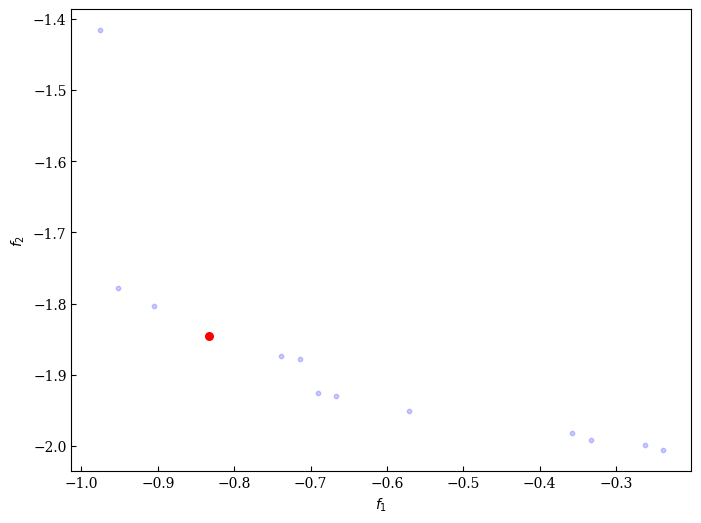

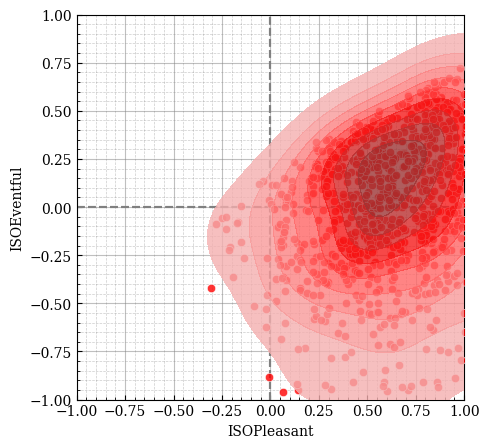

In [12]:
#| label: fig-pymoo-parks
#| fig-cap: "NSGA-II optimization to learn the MSN parameters which produce the Park ranking."
#| fig-subcap:
#|   - "Multi-objective optimization Pareto front. The selected solution is indicated in red."
#|   - "SCM distribution of the derived target distribution."
#| layout-ncol: 2
import matplotlib.pyplot as plt

park_X = park_res.X[park_I]
park_tgt = MultiSkewNorm()
park_tgt.define_dp(
    np.array([park_X[0], park_X[1]]),
    np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
    np.array([park_X[5], park_X[6]]),
)
park_tgt.sample()

# print(park_tgt.summary())

plot = Scatter()
plot.add(park_res.F, color="blue", alpha=0.2, s=10)
plot.add(park_res.F[park_I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()
plt.show()



# park_tgt.sspy_plot()
df = pd.DataFrame(park_tgt.sample_data, columns=["ISOPleasant", "ISOEventful"])
sspy.plotting.density_plot(
    df, color='red', title=None
)
plt.show()

The multi-objective optimization approach presented here demonstrates a systematic method for deriving SPI target distributions from empirical rankings. By simultaneously optimizing for rank correlation and weighted scores, the method produces targets that both preserve ordinal relationships and generate meaningful absolute scores. The park soundscape example shows how this approach can translate qualitative understanding of soundscape quality into quantitative assessment criteria.